# The dynamic malthus model

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [6]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

In this project we solve the dynamic malthusian model. The model is from the course "Economic History" here at KU and it models preindustrial malthusian growth. In this model the parameters as defined as: \
$Y$ is production \
$L$ is labor/population \
$A$ is technology \
$X$ is land, which is constant, a core mechanism \
$n$ is population growthrate \
$\eta$ is how much fertility is correlated with income\
$\mu$ is the mortality rate


The model is defined by the three equations below, where 1. describe how output is a function of labor technology and land, where both land and technology is constant, a core assumption. Equation 2 describes how the population growthrate is positively correlated with income, by the parameter $\eta$, another essenttial assumption. Equation 3 describes how population in the next period is given by the growthrate and the mortality rate. The model is describing how improvements in technology or other factors which would normaly give higher income pr capita will only give higher population as there are fixed amount of land. 

1) $ Y_t = L_t^{1-\alpha}(AX)^\alpha $ 
2) $n_t=\eta y_t \\$
3) $L_{t-1}=n_tL_t +(1-\mu)L_t$

In the analytical solution set $\mu$ equal to 1 as the model will otherwise be to difficult to solve analytically, this means that people only live for 1 period at a time. (This was also what we did in the course when working with the model). When expanding the model we will thereby solve it nummerically by using the equations above, instead of the rewriten version we use below. \
Eq. 3.1 $L_{t-1}=n_tL_t$

## Analytical solution

In this model the two variables of income and population are the main components. In the analytical part we therefore start by solving the model for populaion and then for income. We firstly write of the model and the needed equations and then we begin substituting the different expressions to find the transition equation for population.
The equation is printed below and shows a nice equation following the INADA conditions.

In [7]:
# Define symbols
y_t_1, y_t, Y_t_1, Y_t, L_t, L_t_1, A, X, alpha, eta, n_t, mu = sm.symbols('y_t_1 y_t Y_t_1 Y_t L_t L_t_1 A X alpha eta n_t mu')

# Define equations
equation1 = sm.Eq(Y_t, L_t**(1-alpha) * (A*X)**alpha)  # First equation
equation2 = sm.Eq(n_t, eta * y_t)                      # Second equation
equation3 = sm.Eq(L_t_1, n_t*L_t )                     # Third equation
equation_y = sm.Eq(y_t, Y_t/L_t)                       # Income per person equation


n_t_expr = sm.solve(equation2, n_t)[0] # Solve equation2 for n_t
equation3_substituted = equation3.subs(n_t, n_t_expr) #We substitute the second eqution into the third
equation3_substituted_y = equation3_substituted.subs(y_t, equation_y.rhs)  #We substitute equation for small y into it 
equation3_final = equation3_substituted_y.subs(Y_t, equation1.rhs) #We substitute equation for big Y into it 
equation3_final

Eq(L_t_1, L_t**(1 - alpha)*eta*(A*X)**alpha)

We then use sympy to solve the equation for the steady state value of the population as shown below.

In [8]:
# Change L_t_1 to L_t
equation3_final = equation3_final.subs(L_t_1, L_t)

# Solve the equation for L_t
L_steady_state = sm.solve(equation3_final, L_t)[0]
L_steady_state

(eta*(A*X)**alpha)**(1/alpha)

When looking at income per person, the model can also be solve but as showed above we face problems with exponents in sympy. Why we will show how to get to the transition equation for income for capita. The Analytical solution to the evolution of income pr capita is hence given as: \
$y_{t+1}=\eta^{-\alpha} y_t^{1-\alpha}$ \
We then find the steady state using sympy

In [9]:

# Define the equation
eq = sm.Eq(y_t_1, eta**(-alpha) * y_t**(1-alpha))

# Set y_{t+1} = y_t
eq_substituted = eq.subs(y_t_1, y_t)

# Solve for y_t
solution_y_t = sm.solve(eq_substituted, y_t)
solution_y_t[0]

(eta**(-alpha))**(1/alpha)

In [10]:
simple_solution = sm.simplify(solution_y_t[0])
simple_solution

(eta**(-alpha))**(1/alpha)

As show above with great difficulty by sympy, the solution of the steady state is $y* =\frac{1}{\eta}$

## Numerical solution

We now look at the nummerical solution to the estimation of steady state population. As the equations are all nice monotonic and continuous we dont foresee any problems finding the steady states nummerically. We begin be choosing the parameter estiamtes and then we solve it.

In [11]:
# Constants
alpha = 0.5    # Output elasticity with respect to labor
eta = 0.5     # Adjusted responsiveness of population growth to output (lowered to stabilize)
A = 1          # Technology level
X = 1          # Land availability
L = 10       # Initial population

# Simulation settings
max_iterations = 5000  # Increased maximum iterations
tolerance = 1e-4       # Adjusted tolerance for practicality
previous_population = L

# Iterate to find steady state
for iteration in range(max_iterations):
    # Calculate output pr person
    y = (L ** (- alpha)) * ((A * X) ** alpha)
    # Calculate new population based on the output
    n = eta * y
    L_new = n * L
    
    # Print dynamics to understand behavior
    if iteration % 1000 == 0:  # Print every 1000 iterations to monitor progress
        print(f"Iteration {iteration}: Population = {L_new}")
    
    # Check for convergence
    if np.abs(L_new - previous_population) < tolerance:
        print(f"Steady state reached at iteration {iteration}")
        print(f"Steady state population: {L_new}")
        break
    
    # Update the population for the next iteration
    previous_population = L
    L = L_new

# If loop completes without breaking
if iteration == max_iterations - 1:
    print("Steady state not reached within the maximum number of iterations.")



Iteration 0: Population = 1.5811388300841898
Steady state reached at iteration 14
Steady state population: 0.2500281455009532


In [12]:
print(0.5**(1/0.5))

0.25


Above we found the steady state population which was found after 15 iterations to be within our error. We also calculated the analytic steady state above for the same values, and we can see that they match.

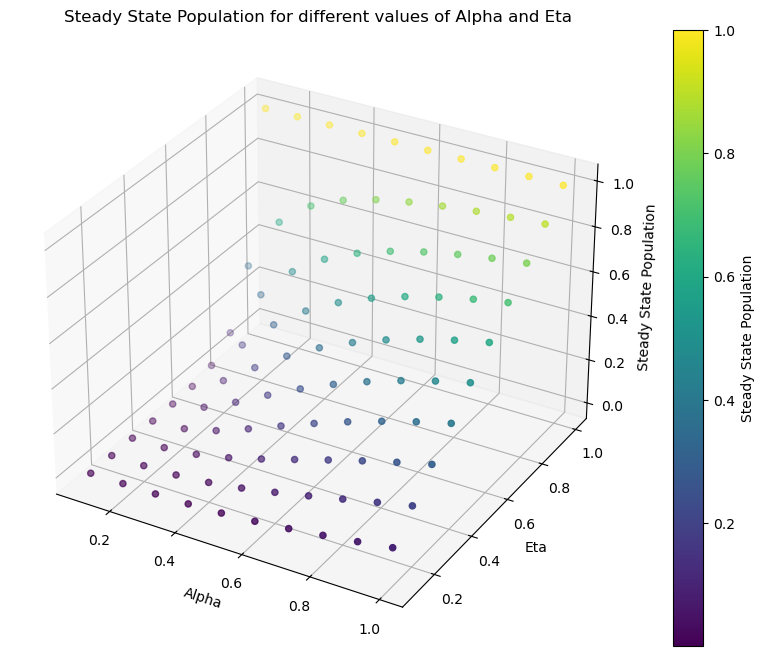

In [13]:
# Parameter ranges
alpha_values = np.linspace(0.1, 1.0, 10)
eta_values = np.linspace(0.1, 1.0, 10)

steady_states = []

for alpha in alpha_values:
    for eta in eta_values:
        L = L_initial
        previous_population = L
        for iteration in range(max_iterations):
            y = (L ** (-alpha)) * ((A * X) ** alpha)
            n = eta * y
            L_new = n * L
            
            if np.abs(L_new - previous_population) < tolerance:
                steady_states.append((alpha, eta, L_new))
                break
            
            previous_population = L
            L = L_new

alpha_vals, eta_vals, populations = zip(*steady_states)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(alpha_vals, eta_vals, populations, c=populations, cmap='viridis')
plt.colorbar(sc, label='Steady State Population')

ax.set_xlabel('Alpha')
ax.set_ylabel('Eta')
ax.set_zlabel('Steady State Population')
ax.set_title('Steady State Population for different values of Alpha and Eta')

plt.show()


# Further analysis

In the following we show the diminishing return og the parameters for the development of the population growth in the Malthus model. 

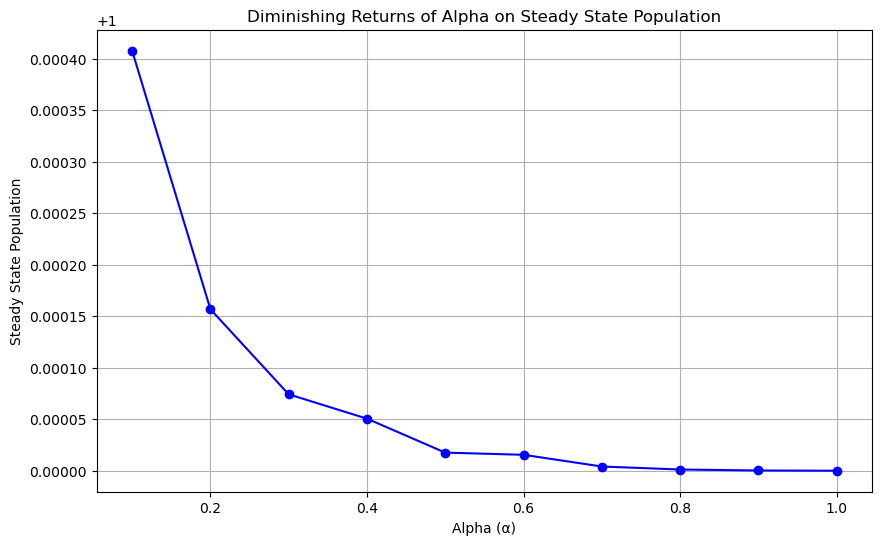

Numerical Results for Fixed Eta: 1.0
Alpha: 0.10, Population: 1.000407558493178
Alpha: 0.20, Population: 1.0001567181000948
Alpha: 0.30, Population: 1.0000741438184588
Alpha: 0.40, Population: 1.0000505129712673
Alpha: 0.50, Population: 1.0000175674844227
Alpha: 0.60, Population: 1.0000154525063742
Alpha: 0.70, Population: 1.0000040789687337
Alpha: 0.80, Population: 1.0000011789242624
Alpha: 0.90, Population: 1.0000002302585358
Alpha: 1.00, Population: 1.0


In [15]:
# Assuming optimal eta is fixed and alpha is varied
optimum_params = steady_states[np.argmax(populations)]
fixed_eta = optimum_params[1]
filtered_alphas = []
filtered_populations = []

for alpha, eta, population in steady_states:
    if eta == fixed_eta:
        filtered_alphas.append(alpha)
        filtered_populations.append(population)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_alphas, filtered_populations, marker='o', linestyle='-', color='b')
plt.title('Diminishing Returns of Alpha on Steady State Population')
plt.xlabel('Alpha (α)')
plt.ylabel('Steady State Population')
plt.grid(True)
plt.show()

# Print numerical solution
print("Numerical Results for Fixed Eta:", fixed_eta)
for alpha, pop in zip(filtered_alphas, filtered_populations):
    print(f"Alpha: {alpha:.2f}, Population: {pop}")


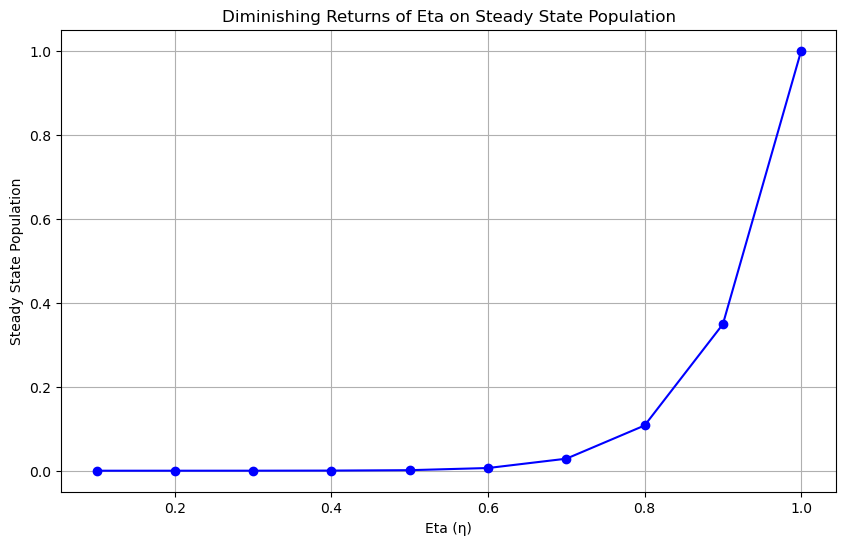

Numerical Results for Fixed Alpha: 0.1
Eta: 0.10, Population: 5.4342461955323115e-06
Eta: 0.20, Population: 3.292702472857067e-05
Eta: 0.30, Population: 8.422081454629195e-05
Eta: 0.40, Population: 0.00032430731516773433
Eta: 0.50, Population: 0.001299065239508905
Eta: 0.60, Population: 0.006450648023140914
Eta: 0.70, Population: 0.028659184076091818
Eta: 0.80, Population: 0.10779343715019567
Eta: 0.90, Population: 0.3490683327824689
Eta: 1.00, Population: 1.000407558493178


In [16]:
# Assuming optimal alpha is fixed and eta is varied
optimum_params = steady_states[np.argmax(populations)]
fixed_alpha = optimum_params[0]
filtered_etas = []
filtered_populations = []

for alpha, eta, population in steady_states:
    if alpha == fixed_alpha:
        filtered_etas.append(eta)
        filtered_populations.append(population)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(filtered_etas, filtered_populations, marker='o', linestyle='-', color='b')
plt.title('Diminishing Returns of Eta on Steady State Population')
plt.xlabel('Eta (η)')
plt.ylabel('Steady State Population')
plt.grid(True)
plt.show()

# Print numerical solution
print("Numerical Results for Fixed Alpha:", fixed_alpha)
for eta, pop in zip(filtered_etas, filtered_populations):
    print(f"Eta: {eta:.2f}, Population: {pop}")



Overall this shows that alpha and eta have an significant effect in the model, for the development of the population. 

# Changes to Model

We now estimate the model with the added mortality to see if we can find a numericall solution.

In [ ]:
# Constants
alpha = 0.5    # Output elasticity with respect to labor
eta = 0.5     # Adjusted responsiveness of population growth to output (lowered to stabilize)
A = 1          # Technology level
X = 1          # Land availability
L = 10       # Initial population
mu = 0.1    # Parameter theta

# Simulation settings
max_iterations = 5000  # Increased maximum iterations
tolerance = 1e-4       # Adjusted tolerance for practicality
previous_population = L

# Iterate to find steady state
for iteration in range(max_iterations):
    # Calculate output per person
    y = (L ** (-alpha)) * ((A * X) ** alpha)
    
    # Calculate new population based on the output
    n = eta * y
    L_new = n * L + (1 - mu) * L
    
    # Print dynamics to understand behavior
    if iteration % 1000 == 0:  # Print every 1000 iterations to monitor progress
        print(f"Iteration {iteration}: Population = {L_new}")
    
    # Check for convergence
    if abs(L_new - previous_population) < tolerance:
        print(f"Steady state reached at iteration {iteration}")
        print(f"Steady state population: {L_new}")
        break
    
    # Update the population for the next iteration
    previous_population = L
    L = L_new

# If loop completes without breaking
if iteration == max_iterations - 1:
    print("Steady state not reached within the maximum number of iterations.")

Iteration 0: Population = 10.581138830084189
Steady state reached at iteration 193
Steady state population: 24.999113068115236


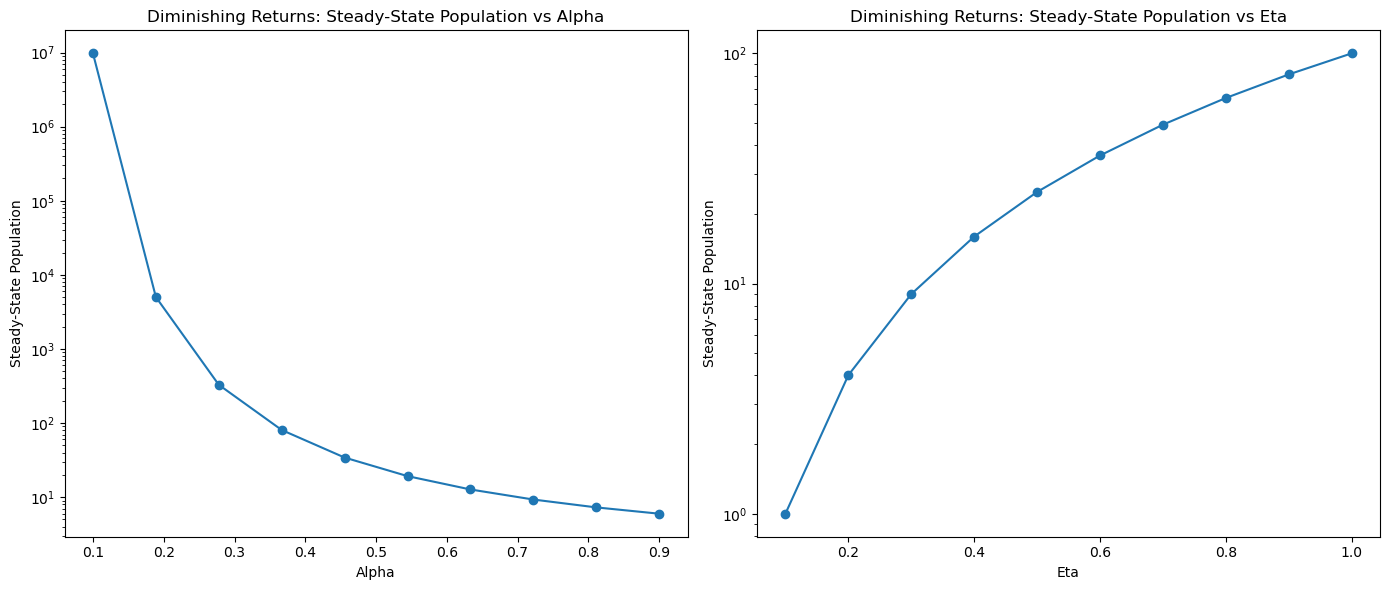

In [ ]:
plt.figure(figsize=(14, 6))

# Diminishing returns for alpha
plt.subplot(1, 2, 1)
plt.plot(alpha_values, alpha_sensitivity, marker='o')
plt.title('Diminishing Returns: Steady-State Population vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Steady-State Population')
plt.yscale('log')  # Using log scale to emphasize diminishing returns

# Diminishing returns for eta
plt.subplot(1, 2, 2)
plt.plot(eta_values, eta_sensitivity, marker='o')
plt.title('Diminishing Returns: Steady-State Population vs Eta')
plt.xlabel('Eta')
plt.ylabel('Steady-State Population')
plt.yscale('log')  # Using log scale to emphasize diminishing returns

plt.tight_layout()
plt.show()


As seen for the curves showing diminishing return in the model with mortality, we can see that the alpha-parameter develops the same in both the model with and without mortality. For eta on the other hand, we can see that it goes from linear to having a diminishing return, when increasing eta. 

# Conclusion

In this excercie we have investigated the dynamic malthus model and showed how the population in this model ends in steady state. A steady state heavily influnced by the parameter choiches of Alpha and Eta respectively being Output elasticity with respect to labor and responsiveness of population growth to output. When alpha is small, increases in alpha rapidly decrease population, an effect which slows down as alpha increases, while Eta has a linear positive effect.
We can also see how we found a steady state when including mortality, which was much higher, as we now allowed poeple to live more than one period.